In [1]:
import pandas as pd
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

### Merging different sets of metrics in one dataframe

In [2]:
def classification(to_convert):
    final_list=[]
    for i in to_convert:
        if i>0.08:
            final_list.append(1)
        else:
            final_list.append(0)
    return final_list

### Separating features and target and feature scaling

In [3]:
df = pd.read_csv('kc1.csv')
df.dropna()

#Removing the actual bug count column to extract the metrics
X = df.loc[:, df.columns != 'defects']
Y = df['defects']

##print(X.dtypes)

X = X.apply(pd.to_numeric)
##print(X.head())
X_asDF = X

# Feature Scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

Y = [(float(i)-min(Y))/(max(Y)-min(Y)) for i in Y]

### Extracting top 5 metrics and calculating Ru

### Simple Linear Regression

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
feature_scores = {}
r_scores = []

from sklearn.linear_model import LinearRegression
import operator

reg = LinearRegression()

for i in range(X_train.shape[1]):
    reg.fit(X_train[:,i].reshape(-1,1),Y_train)
    feature_scores[i] = reg.score(X_train[:,i].reshape(-1,1),Y_train)

sorted_feature_scores = dict(sorted(feature_scores.items(), key=operator.itemgetter(1),reverse=True))


dict_items = sorted_feature_scores.items()

top_n_metrics = list(dict_items)[:5]
print(top_n_metrics)
#print(X_asDF.columns[top_n_metrics[0][0]])

list_keys = [x[0] for x in top_n_metrics]
print(X_asDF.columns[list_keys])
#print(list_keys)
X_train_for_multiple  = X_train[:,list_keys]
X_test_for_multiple  = X_test[:,list_keys]
reg.fit(X_train_for_multiple, Y_train)

rU = reg.score(X_train_for_multiple, Y_train)
print(rU)

[(7, 0.15286654340971373), (17, 0.15167318530644902), (16, 0.1493627837895436), (19, 0.13253658760465992), (4, 0.12694486218079892)]
Index(['d', 'uniq_Opnd', 'uniq_Op', 'total_Opnd', 'n'], dtype='object')
0.18131911782010524


### Applying proposed algorithm with Polynomial Regression

In [7]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 2)
X_poly = poly.fit_transform(X)


poly.fit(X_poly,Y)
X_train, X_test, Y_train, Y_test = train_test_split(X_poly, Y, test_size=0.2, random_state=1)
feature_scores = {}
r_scores = []

# Fitting Polynomial Regression to the dataset

from sklearn.linear_model import LinearRegression, Lasso
import operator

reg = LinearRegression() 
for i in range(X_train.shape[1]):
    reg.fit(X_train[:,i].reshape(-1,1),Y_train)
    feature_scores[i] = reg.score(X_train[:,i].reshape(-1,1),Y_train)

sorted_feature_scores = dict( sorted(feature_scores.items(), key=operator.itemgetter(1),reverse=True))


dict_items = sorted_feature_scores.items()

top_n_metrics = list(dict_items)[:5]
#print(top_n_metrics)
#print(X_asDF.columns[top_n_metrics[0][0]])

list_keys = [x[0] for x in top_n_metrics]
#print(list_keys)
X_train_for_multiple  = X_train[:,list_keys]
X_test_for_multiple  = X_test[:,list_keys]
reg.fit(X_train_for_multiple, Y_train)

rU = reg.score(X_train_for_multiple, Y_train)
print(rU)

0.5531120727134429


### Proposed Algorithm with Ridge Regression

In [8]:
feature_scores = {}
r_scores = []

# Fitting Polynomial Regression to the dataset

from sklearn.linear_model import LinearRegression, Lasso, Ridge
import operator

reg = Ridge() 
for i in range(X_train.shape[1]):
    reg.fit(X_train[:,i].reshape(-1,1),Y_train)
    feature_scores[i] = reg.score(X_train[:,i].reshape(-1,1),Y_train)

sorted_feature_scores = dict(sorted(feature_scores.items(), key=operator.itemgetter(1),reverse=True))

dict_items = sorted_feature_scores.items()

top_n_metrics = list(dict_items)[:5]

list_keys = [x[0] for x in top_n_metrics]

X_train_for_multiple  = X_train[:,list_keys]
X_for_proposed = X[:,list_keys]
X_test_for_multiple  = X_test[:,list_keys]
reg.fit(X_train_for_multiple, Y_train)

rU = reg.score(X_train_for_multiple, Y_train)
print(rU)

IndexError: index 926 is out of bounds for axis 1 with size 42

### Calculating weights for the selected features

In [6]:
d = []
for i in list_keys:
    remaining_features = [j for j in list_keys if j != i ]
    X_train_remaining = X_train[:,remaining_features]
    X_test_remaining = X_test[:,remaining_features]
    reg.fit(X_train_remaining, Y_train)
    train_score = reg.score(X_train_remaining, Y_train)
    print(train_score)
    d.append(rU-train_score)

0.16827851111064374
0.1664253516878873
0.17859217448718012
0.18126935749208384
0.17722861536804135


### Normalising weights for and predicting the bug proneness index

In [7]:
norm_d = [(float(i)-min(d))/(max(d)-min(d)) for i in d]
print(norm_d)
#Weights should be mapped to elements in the list_keys
#norm_d are the normalized weights of the n metrics
Y_pred = []
for features_test in X_test:
    tot = 0
    for (i, wt) in zip(list_keys, norm_d):
        tot = tot + features_test[i] * wt
    Y_pred.append(tot)
Y_pred = [(float(i)-min(Y_pred))/(max(Y_pred)-min(Y_pred)) for i in Y_pred]
  

[0.8751577271525636, 1.0, 0.18035448383797129, 0.0, 0.2722137256844867]


### Printing the predicted and the actual target

In [8]:
## The paper doesn't mention normalising again but some values don't lie in the range of 0 to 1
## Hence normalising again
Y_pred = [(float(i)-min(Y_pred))/(max(Y_pred)-min(Y_pred)) for i in Y_pred]
Y_pred_final = [round(i,4) for i in Y_pred]
Y_test_final = [round(i,4) for i in Y_test]

"""
for(predicted, actual) in zip(Y_pred_final, Y_test_final):
    print(f"{predicted} - {actual}") 
    print()
"""

'\nfor(predicted, actual) in zip(Y_pred_final, Y_test_final):\n    print(f"{predicted} - {actual}") \n    print()\n'

## Function to classify bug count to 0 or 1

In [9]:
from imblearn.over_sampling import SMOTE
Y_train_classified = classification(Y_train)
Y_test_classified = classification(Y_test)
Y_pred_classified=classification(Y_pred_final)

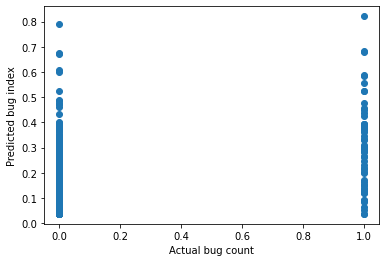

In [10]:
# Plotting of simple linear regression model

import matplotlib.pyplot as plt
X_train_for_singlefeat = X_train[:,list_keys[0]]
X_single_feat = X[:,list_keys[0]]
X_single_feat_2d = X_single_feat.reshape(-1,1)
X_test_for_singlefeat = X_test[:,list_keys[0]]
X_train_for_singlefeat_2d = X_train_for_singlefeat.reshape(-1,1)
reg.fit(X_train_for_singlefeat_2d,Y_train)
X_test_for_singlefeat_2d = X_test_for_singlefeat.reshape(-1,1)
Y_Predicted = reg.predict(X_test_for_singlefeat_2d)
plt.xlabel("Actual bug count")
plt.ylabel("Predicted bug index")
plt.scatter(Y_test_final,Y_Predicted)

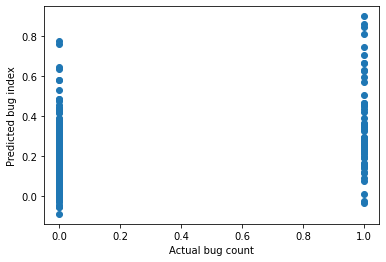

In [11]:
# Plotting of multiple linear regression

reg.fit(X_train,Y_train)
Y_Pred_multiplereg = reg.predict(X_test)
plt.xlabel("Actual bug count")
plt.ylabel("Predicted bug index")
plt.scatter(Y_test,Y_Pred_multiplereg)


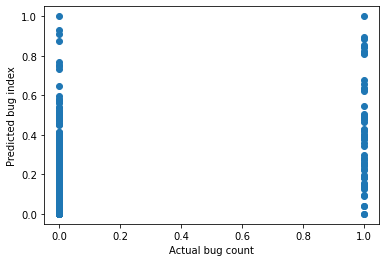

In [12]:
# Plotting of prosposed model
plt.xlabel("Actual bug count")
plt.ylabel("Predicted bug index")
plt.scatter(Y_test_final,Y_pred_final)


## Classificaton report for testing data
### Simple Linear regression

In [13]:
from sklearn.metrics import classification_report
reg.fit(X_train_for_singlefeat_2d,Y_train)
Y_pred_simple = reg.predict(X_test_for_singlefeat_2d)
print("Classification report : ")
print(classification_report(classification(Y_test), classification(Y_pred_simple)))

Classification report : 
              precision    recall  f1-score   support

           0       0.97      0.41      0.58       364
           1       0.20      0.93      0.33        58

    accuracy                           0.48       422
   macro avg       0.59      0.67      0.46       422
weighted avg       0.87      0.48      0.55       422



### Multiple Linear regression

In [14]:
reg.fit(X_train,Y_train)
Y_pred_multiple = reg.predict(X_test)
print("Classification report : ")
print(classification_report(classification(Y_test), classification(Y_pred_multiple)))

Classification report : 
              precision    recall  f1-score   support

           0       0.98      0.46      0.62       364
           1       0.21      0.93      0.35        58

    accuracy                           0.52       422
   macro avg       0.60      0.69      0.49       422
weighted avg       0.87      0.52      0.58       422



### Proposed model

In [15]:
Y_pred = []
for features_test in X_test:
    tot = 0
    for (i, wt) in zip(list_keys, norm_d):
        tot = tot + features_test[i] * wt
    Y_pred.append(tot)
Y_pred = [(float(i)-min(Y_pred))/(max(Y_pred)-min(Y_pred)) for i in Y_pred]
print("Classification report : ")
print(classification_report(classification(Y_test), classification(Y_pred)))

Classification report : 
              precision    recall  f1-score   support

           0       0.98      0.47      0.64       364
           1       0.22      0.93      0.36        58

    accuracy                           0.54       422
   macro avg       0.60      0.70      0.50       422
weighted avg       0.87      0.54      0.60       422



In [16]:
# Accuracy - 3 
# Precision - 3
# Recall - 3
# F measure - 3

### Classification report for Training Data

### Simple Linear Regression

In [17]:
reg.fit(X_train_for_singlefeat_2d,Y_train)
Y_pred_simple = reg.predict(X_train_for_singlefeat_2d)
print("Classification report : ")
print(classification_report(classification(Y_train), classification(Y_pred_simple)))

Classification report : 
              precision    recall  f1-score   support

           0       0.97      0.43      0.60      1419
           1       0.24      0.94      0.38       268

    accuracy                           0.51      1687
   macro avg       0.61      0.68      0.49      1687
weighted avg       0.86      0.51      0.56      1687



### Multiple Linear Regression

In [18]:
reg.fit(X_train,Y_train)
Y_pred_multiple = reg.predict(X_train)
print("Classification report : ")
print(classification_report(classification(Y_train), classification(Y_pred_multiple)))

Classification report : 
              precision    recall  f1-score   support

           0       0.97      0.47      0.64      1419
           1       0.25      0.93      0.39       268

    accuracy                           0.55      1687
   macro avg       0.61      0.70      0.52      1687
weighted avg       0.86      0.55      0.60      1687



### Proposed Model

In [19]:
Y_pred = []
for features_train in X_train:
    tot = 0
    for (i, wt) in zip(list_keys, norm_d):
        tot = tot + features_train[i] * wt
    Y_pred.append(tot)
Y_pred = [(float(i)-min(Y_pred))/(max(Y_pred)-min(Y_pred)) for i in Y_pred]
print("Classification report : ")
print(classification_report(classification(Y_train), classification(Y_pred)))

Classification report : 
              precision    recall  f1-score   support

           0       0.95      0.61      0.74      1419
           1       0.28      0.83      0.42       268

    accuracy                           0.64      1687
   macro avg       0.62      0.72      0.58      1687
weighted avg       0.84      0.64      0.69      1687



In [20]:
# Accuracy - 2
# Precision - 2
# Recall - 2
# F measure - 2

### Classification Report for overall data

### Simple Linear Regression

In [21]:
reg.fit(X_train_for_singlefeat_2d,Y_train)
Y_pred_simple = reg.predict(X_single_feat_2d)
print("Classification report : ")
print(classification_report(classification(Y), classification(Y_pred_simple)))

Classification report : 
              precision    recall  f1-score   support

           0       0.97      0.43      0.60      1783
           1       0.23      0.94      0.37       326

    accuracy                           0.51      2109
   macro avg       0.60      0.68      0.48      2109
weighted avg       0.86      0.51      0.56      2109



### Multiple Linear Regression

In [22]:
reg.fit(X_train,Y_train)
Y_pred_overall = reg.predict(X)
print("Classification report : ")
print(classification_report(classification(Y), classification(Y_pred_overall)))

Classification report : 
              precision    recall  f1-score   support

           0       0.97      0.47      0.63      1783
           1       0.24      0.93      0.38       326

    accuracy                           0.54      2109
   macro avg       0.61      0.70      0.51      2109
weighted avg       0.86      0.54      0.60      2109



### Proposed Model

In [23]:
Y_pred = []
for features in X:
    tot = 0
    for (i, wt) in zip(list_keys, norm_d):
        tot = tot + features[i] * wt
    Y_pred.append(tot)
Y_pred = [(float(i)-min(Y_pred))/(max(Y_pred)-min(Y_pred)) for i in Y_pred]
print("Classification report : ")
print(classification_report(classification(Y), classification(Y_pred)))

Classification report : 
              precision    recall  f1-score   support

           0       0.95      0.60      0.74      1783
           1       0.28      0.84      0.42       326

    accuracy                           0.64      2109
   macro avg       0.62      0.72      0.58      2109
weighted avg       0.85      0.64      0.69      2109



In [24]:
# Accuracy - 3
# Precision - 2
# Recall - 3
# F measure - 3

In [25]:

f1_simple = [0.82,0.83,0.83]
acc_simple = [0.83,0.84,0.84]
prec_simple = [0.81,0.83,0.83]
rec_simple = [0.83,0.84,0.84]

f1_multiple = [0.82,0.85,0.84]
acc_multiple = [0.82,0.86,0.85]
prec_multiple = [0.82,0.85,0.84]
rec_multiple = [0.82,0.86,0.85]

f1_proposed = [0.84,0.84,0.84]
acc_proposed = [0.84,0.85,0.85]
prec_proposed = [0.84,0.84,0.84]
rec_proposed = [0.84,0.85,0.85]

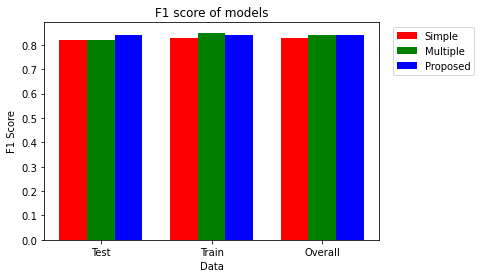

In [26]:
N = 3
ind = np.arange(N) 
width = 0.25  
bar1 = plt.bar(ind, f1_simple, width, color = 'r')
bar2 = plt.bar(ind+width, f1_multiple, width, color='g')
bar3 = plt.bar(ind+width*2, f1_proposed, width, color = 'b')
  
plt.xlabel("Data")
plt.ylabel("F1 Score")
plt.title("F1 score of models")
  
plt.xticks(ind+width,['Test', 'Train', 'Overall'])
plt.legend( (bar1, bar2, bar3), ('Simple', 'Multiple', 'Proposed'),bbox_to_anchor =(1.3, 1.0) )
plt.show()

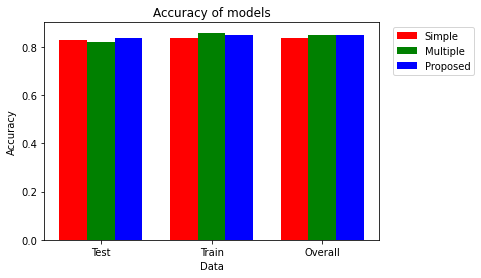

In [27]:
N = 3
ind = np.arange(N) 
width = 0.25  
bar1 = plt.bar(ind, acc_simple, width, color = 'r')
bar2 = plt.bar(ind+width, acc_multiple, width, color='g')
bar3 = plt.bar(ind+width*2, acc_proposed, width, color = 'b')
  
plt.xlabel("Data")
plt.ylabel("Accuracy")
plt.title("Accuracy of models")
  
plt.xticks(ind+width,['Test', 'Train', 'Overall'])
plt.legend( (bar1, bar2, bar3), ('Simple', 'Multiple', 'Proposed'),bbox_to_anchor =(1.3, 1.0) )
plt.show()

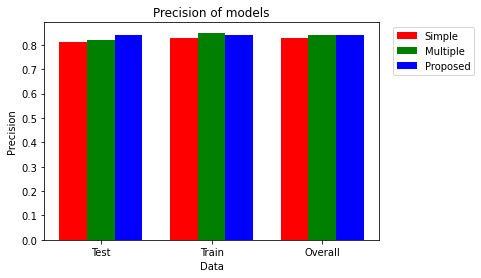

In [28]:
N = 3
ind = np.arange(N) 
width = 0.25  
bar1 = plt.bar(ind, prec_simple, width, color = 'r')
bar2 = plt.bar(ind+width, prec_multiple, width, color='g')
bar3 = plt.bar(ind+width*2, prec_proposed, width, color = 'b')
  
plt.xlabel("Data")
plt.ylabel("Precision")
plt.title("Precision of models")
  
plt.xticks(ind+width,['Test', 'Train', 'Overall'])
plt.legend( (bar1, bar2, bar3), ('Simple', 'Multiple', 'Proposed'),bbox_to_anchor =(1.3, 1.0) )
plt.show()

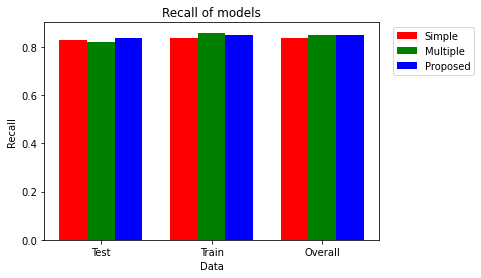

In [29]:
N = 3
ind = np.arange(N) 
width = 0.25  
bar1 = plt.bar(ind, rec_simple, width, color = 'r')
bar2 = plt.bar(ind+width, rec_multiple, width, color='g')
bar3 = plt.bar(ind+width*2, rec_proposed, width, color = 'b')
  
plt.xlabel("Data")
plt.ylabel("Recall")
plt.title("Recall of models")
  
plt.xticks(ind+width,['Test', 'Train', 'Overall'])
plt.legend( (bar1, bar2, bar3), ('Simple', 'Multiple', 'Proposed'),bbox_to_anchor =(1.3, 1.0) )
plt.show()

### Applying classification models to the proposed model(5 selected features)

In [37]:
acc_scores = []
f1_scores = []

from sklearn.naive_bayes import GaussianNB, ComplementNB
clf = GaussianNB()
Y_train_clf = classification(Y_train)
Y_test_clf = classification(Y_test)
clf.fit(X_train_for_multiple, Y_train_clf)
Y_pred = clf.predict(X_test_for_multiple)

from sklearn.metrics import f1_score,accuracy_score,classification_report
print("Classification report : ")
print(classification_report(Y_test_clf, classification(Y_pred)))

acc_scores.append(accuracy_score(Y_test_clf, classification(Y_pred)))
f1_scores.append(f1_score(Y_test_clf, classification(Y_pred), average = 'weighted'))

Classification report : 
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       364
           1       0.39      0.41      0.40        58

    accuracy                           0.83       422
   macro avg       0.65      0.66      0.65       422
weighted avg       0.84      0.83      0.83       422



In [38]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion = "entropy", splitter="random",min_samples_split=3)
clf.fit(X_train_for_multiple, Y_train_clf)
Y_pred = clf.predict(X_test_for_multiple)
print("Classification report : ")
print(classification_report(Y_test_clf, classification(Y_pred)))
acc_scores.append(accuracy_score(Y_test_clf, classification(Y_pred)))
f1_scores.append(f1_score(Y_test_clf, classification(Y_pred), average = 'weighted'))

Classification report : 
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       364
           1       0.38      0.36      0.37        58

    accuracy                           0.83       422
   macro avg       0.64      0.63      0.64       422
weighted avg       0.83      0.83      0.83       422



In [39]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='saga', penalty = 'l2', C = 0.1, random_state=10)
clf.fit(X_train_for_multiple, Y_train_clf)
Y_pred = clf.predict(X_test_for_multiple)
print("Classification report : ")
print(classification_report(Y_test_clf, classification(Y_pred)))
acc_scores.append(accuracy_score(Y_test_clf, classification(Y_pred)))
f1_scores.append(f1_score(Y_test_clf, classification(Y_pred), average = 'weighted'))

Classification report : 
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       364
           1       0.50      0.05      0.09        58

    accuracy                           0.86       422
   macro avg       0.68      0.52      0.51       422
weighted avg       0.82      0.86      0.81       422



In [40]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=35)
clf.fit(X_train_for_multiple, Y_train_clf)
Y_pred = clf.predict(X_test_for_multiple)
print("Classification report : ")
print(classification_report(Y_test_clf, classification(Y_pred)))
acc_scores.append(accuracy_score(Y_test_clf, classification(Y_pred)))
f1_scores.append(f1_score(Y_test_clf, classification(Y_pred), average = 'weighted'))

Classification report : 
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       364
           1       0.56      0.17      0.26        58

    accuracy                           0.87       422
   macro avg       0.72      0.58      0.60       422
weighted avg       0.84      0.87      0.84       422



In [41]:
from sklearn.ensemble import RandomForestClassifier
rfs = RandomForestClassifier(n_estimators=300, criterion = "gini")
rfs.fit(X_train_for_multiple, Y_train_clf)
Y_pred = rfs.predict(X_test_for_multiple)
print("Classification report : ")
print(classification_report(Y_test_clf, classification(Y_pred)))

acc_scores.append(accuracy_score(Y_test_clf, classification(Y_pred)))
f1_scores.append(f1_score(Y_test_clf, classification(Y_pred), average = 'weighted'))

Classification report : 
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       364
           1       0.46      0.31      0.37        58

    accuracy                           0.86       422
   macro avg       0.68      0.63      0.64       422
weighted avg       0.84      0.86      0.84       422



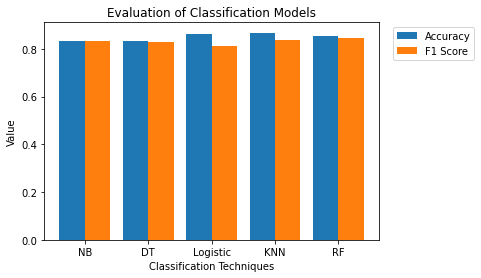

In [42]:
X = ["NB", "DT","Logistic", "KNN", "RF"]
X_axis = np.arange(len(X))  
plt.bar(X_axis - 0.2, acc_scores, 0.4, label = 'Accuracy')
plt.bar(X_axis + 0.2, f1_scores, 0.4, label = 'F1 Score')
plt.xticks(X_axis, X)
plt.xlabel("Classification Techniques")
plt.ylabel("Value")
plt.title("Evaluation of Classification Models")
plt.legend(bbox_to_anchor =(1.3, 1.0))
plt.show()

In [43]:
len(acc_scores)

5